<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [1]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv2D, Flatten, MaxPooling2D
from keras.preprocessing import sequence
from keras.layers import Conv1D
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport

[MacBook-Pro-de-Genereux.local:12196] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/31588352/sm_segment.MacBook-Pro-de-Genereux.501.1e20000.0 could be created.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1-1 Generatige Dataset

In [3]:
dataset_path   = "../data/raw_data/"
gene_info_path = "../data/gene_info.json"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [4]:
gene_class_encoding = {gene['file_code']:i for i, gene in enumerate(gene_info.values())}

In [5]:
df_list = []
for filename in os.listdir(dataset_path):
    if filename.endswith(".fas"):
        file_path = os.path.join(dataset_path, filename)
        df = fasta.read(file_path, gene_class_encoding[filename.split('.')[0]])
        df_list.append(df)

# Concatenate all dataframes
dataset = pd.concat(df_list, ignore_index=True)
dataset.to_csv("../data/merged/full_df.csv")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320370 entries, 0 to 320369
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        320370 non-null  object
 1   sequence  320370 non-null  object
 2   length    320370 non-null  int64 
 3   class     320370 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.8+ MB


In [ ]:
class_counts = dataset['class'].value_counts()
total_samples = len(dataset)
class_counts_df = pd.DataFrame(class_counts)
class_counts_df.columns = ['Count']
class_counts_df['Percentage'] = (class_counts_df['Count'] / total_samples * 100).round(2)

print("Class Distribution:")
print(class_counts_df)
print("\nTotal Samples:", total_samples)

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [195]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [196]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [197]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [203]:
dataset.head()

,id,sequence,length,class
0,Achn002551,MKRIENATSRQVTFSKRRNGLLKKAFELSVLCDAEVALIIFSNKGR...,126,30
1,Achn015591,MGRSVKHESITNERVRRQTFQKRKAGLFKKVSELQTLCGHDACAVI...,165,30
2,Achn041671,MAREKIKIKKIDNITARQVTFSKRRRGLFKKAEELAVLCDAEVALI...,93,30
3,Achn041761,MGRGKIVIRRIDNSTSRQVTFSKRRNGLLKKAKELAILCDAEVGVI...,91,30
4,Achn058181,MTRNKINLALIANESSRKATLKKRRASMFKKIEELSVLSDVRTGAI...,253,30


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320370 entries, 0 to 320369
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        320370 non-null  object
 1   sequence  320370 non-null  object
 2   length    320370 non-null  int64 
 3   class     320370 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.8+ MB


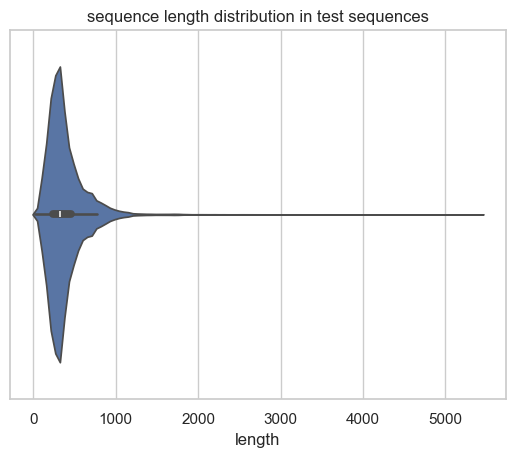

In [8]:
sns.set(style="whitegrid")
sns.violinplot(x=dataset.length)
plt.title("sequence length distribution in test sequences")
plt.show()

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-CNN/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def visualize_matrix(matrix, ax, title="Matrix Visualization"):
    ax.imshow(matrix, aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.axis('off')

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>SIMPLE CNN</li></ul>
</h4>

* **Fromating method**

In [11]:
def build_protein_histogram(dataset, k=50, slide=1, length=10):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'
    
    def calculate_frequencies(sequence, k, length):
        histogram = np.zeros((length, len(amino_acids)))
        for i in range(length):
            #print(i*k, (i*k) + k)
            segment = sequence[i*slide:(i*slide) + k]
            freqs = np.zeros(len(amino_acids))
            for aa in segment:
                if aa in amino_acids:
                    freqs[amino_acids.index(aa)] += 1
                else:
                    freqs[amino_acids.index('X')] += 1
            freqs /= k
            histogram[i, :] = freqs
        return histogram
    
    histograms = []
    labels = []
    
    for _, row in dataset.iterrows():
        sequence = row['sequence']
        label = row['class']
        
        if len(sequence) < k + length - 1:
            continue
        
        hist = calculate_frequencies(sequence, k, length)
        histograms.append(hist)
        labels.append(label)
    
    return np.array(histograms), np.array(labels)

In [12]:
X, y = build_protein_histogram(dataset, k=50, slide=1, length=32)
print(X.shape)
print(y)

(316790, 32, 21)
[30 30 30 ... 57 57 57]


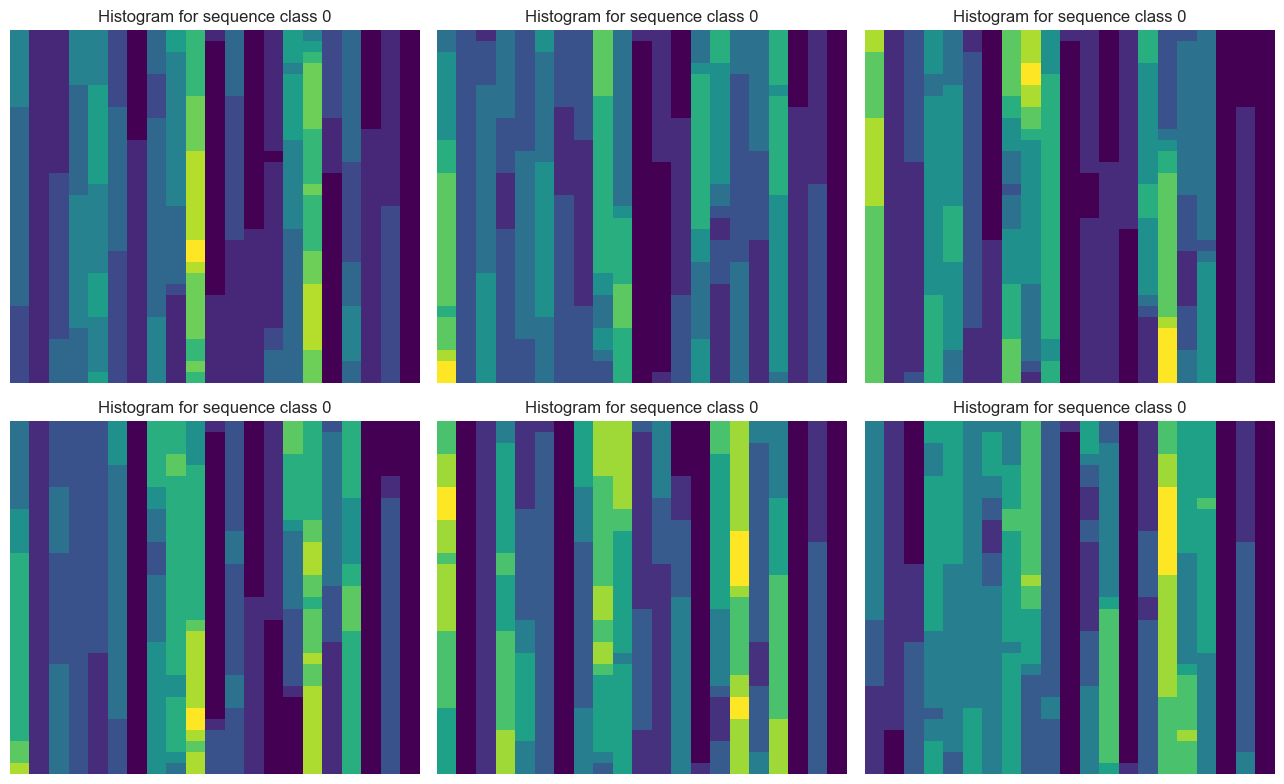

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
for i in range(6):
    row = i // 3
    col = i % 3
    visualize_matrix(X[i], axes[row, col], title=f"Histogram for sequence class {np.argmax(y[i])}")

plt.tight_layout()
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42

In [15]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = len(gene_class_encoding) #1
SEQ_LENGTH = X_train.shape[1]

X_train: (253432, 32, 21)
X_test: (63358, 32, 21)
y_train: (253432,)
y_test: (63358,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : SIMPLE CNN</span>

In [20]:
name="CNN-FEEDFORWARD"
def cnn_model1():
    model = Sequential(name=name)
    model.add(Input(shape=(X.shape[1], X.shape[2], 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Flatten()),
    model.add(Dense(128, activation='relu')),
    model.add(Dense(NUM_CLASS, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #binary_crossentropy
    model.summary()
    return model

# Build & train the model
model = cnn_model1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "CNN-FEEDFORWARD"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 19, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       553,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,890 (2.14 MB)

 Trainable params: 560,890 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.3500 - loss: 2.5577 - val_accuracy: 0.5213 - val_loss: 1.8737
Epoch 2/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5395 - loss: 1.7862 - val_accuracy: 0.5757 - val_loss: 1.6607
Epoch 3/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.5799 - loss: 1.6268 - val_accuracy: 0.6033 - val_loss: 1.5605
Epoch 4/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6071 - loss: 1.5288 - val_accuracy: 0.6172 - val_loss: 1.5215
Epoch 5/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.6250 - loss: 1.4653 - val_accuracy: 0.6241 - val_loss: 1.4891
Epoch 6/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6382 - loss: 1.4152 - val_accuracy: 0.6378 - val_loss: 1.4416
Epoch 7/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6481 - loss: 1.3798 - val_accuracy: 0.6442 - val_loss: 1.4178
Epoch 8/100
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6580 -

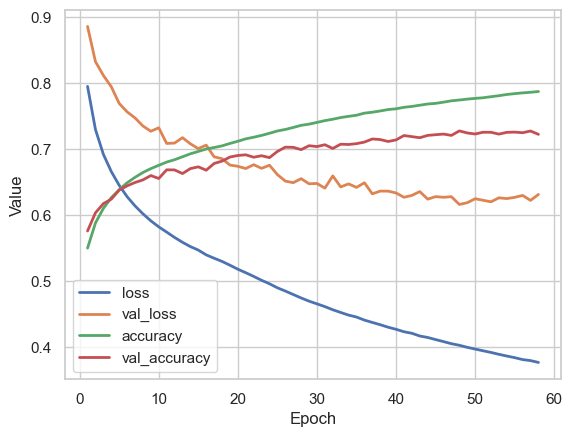

In [21]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [23]:
# Get predictions from the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


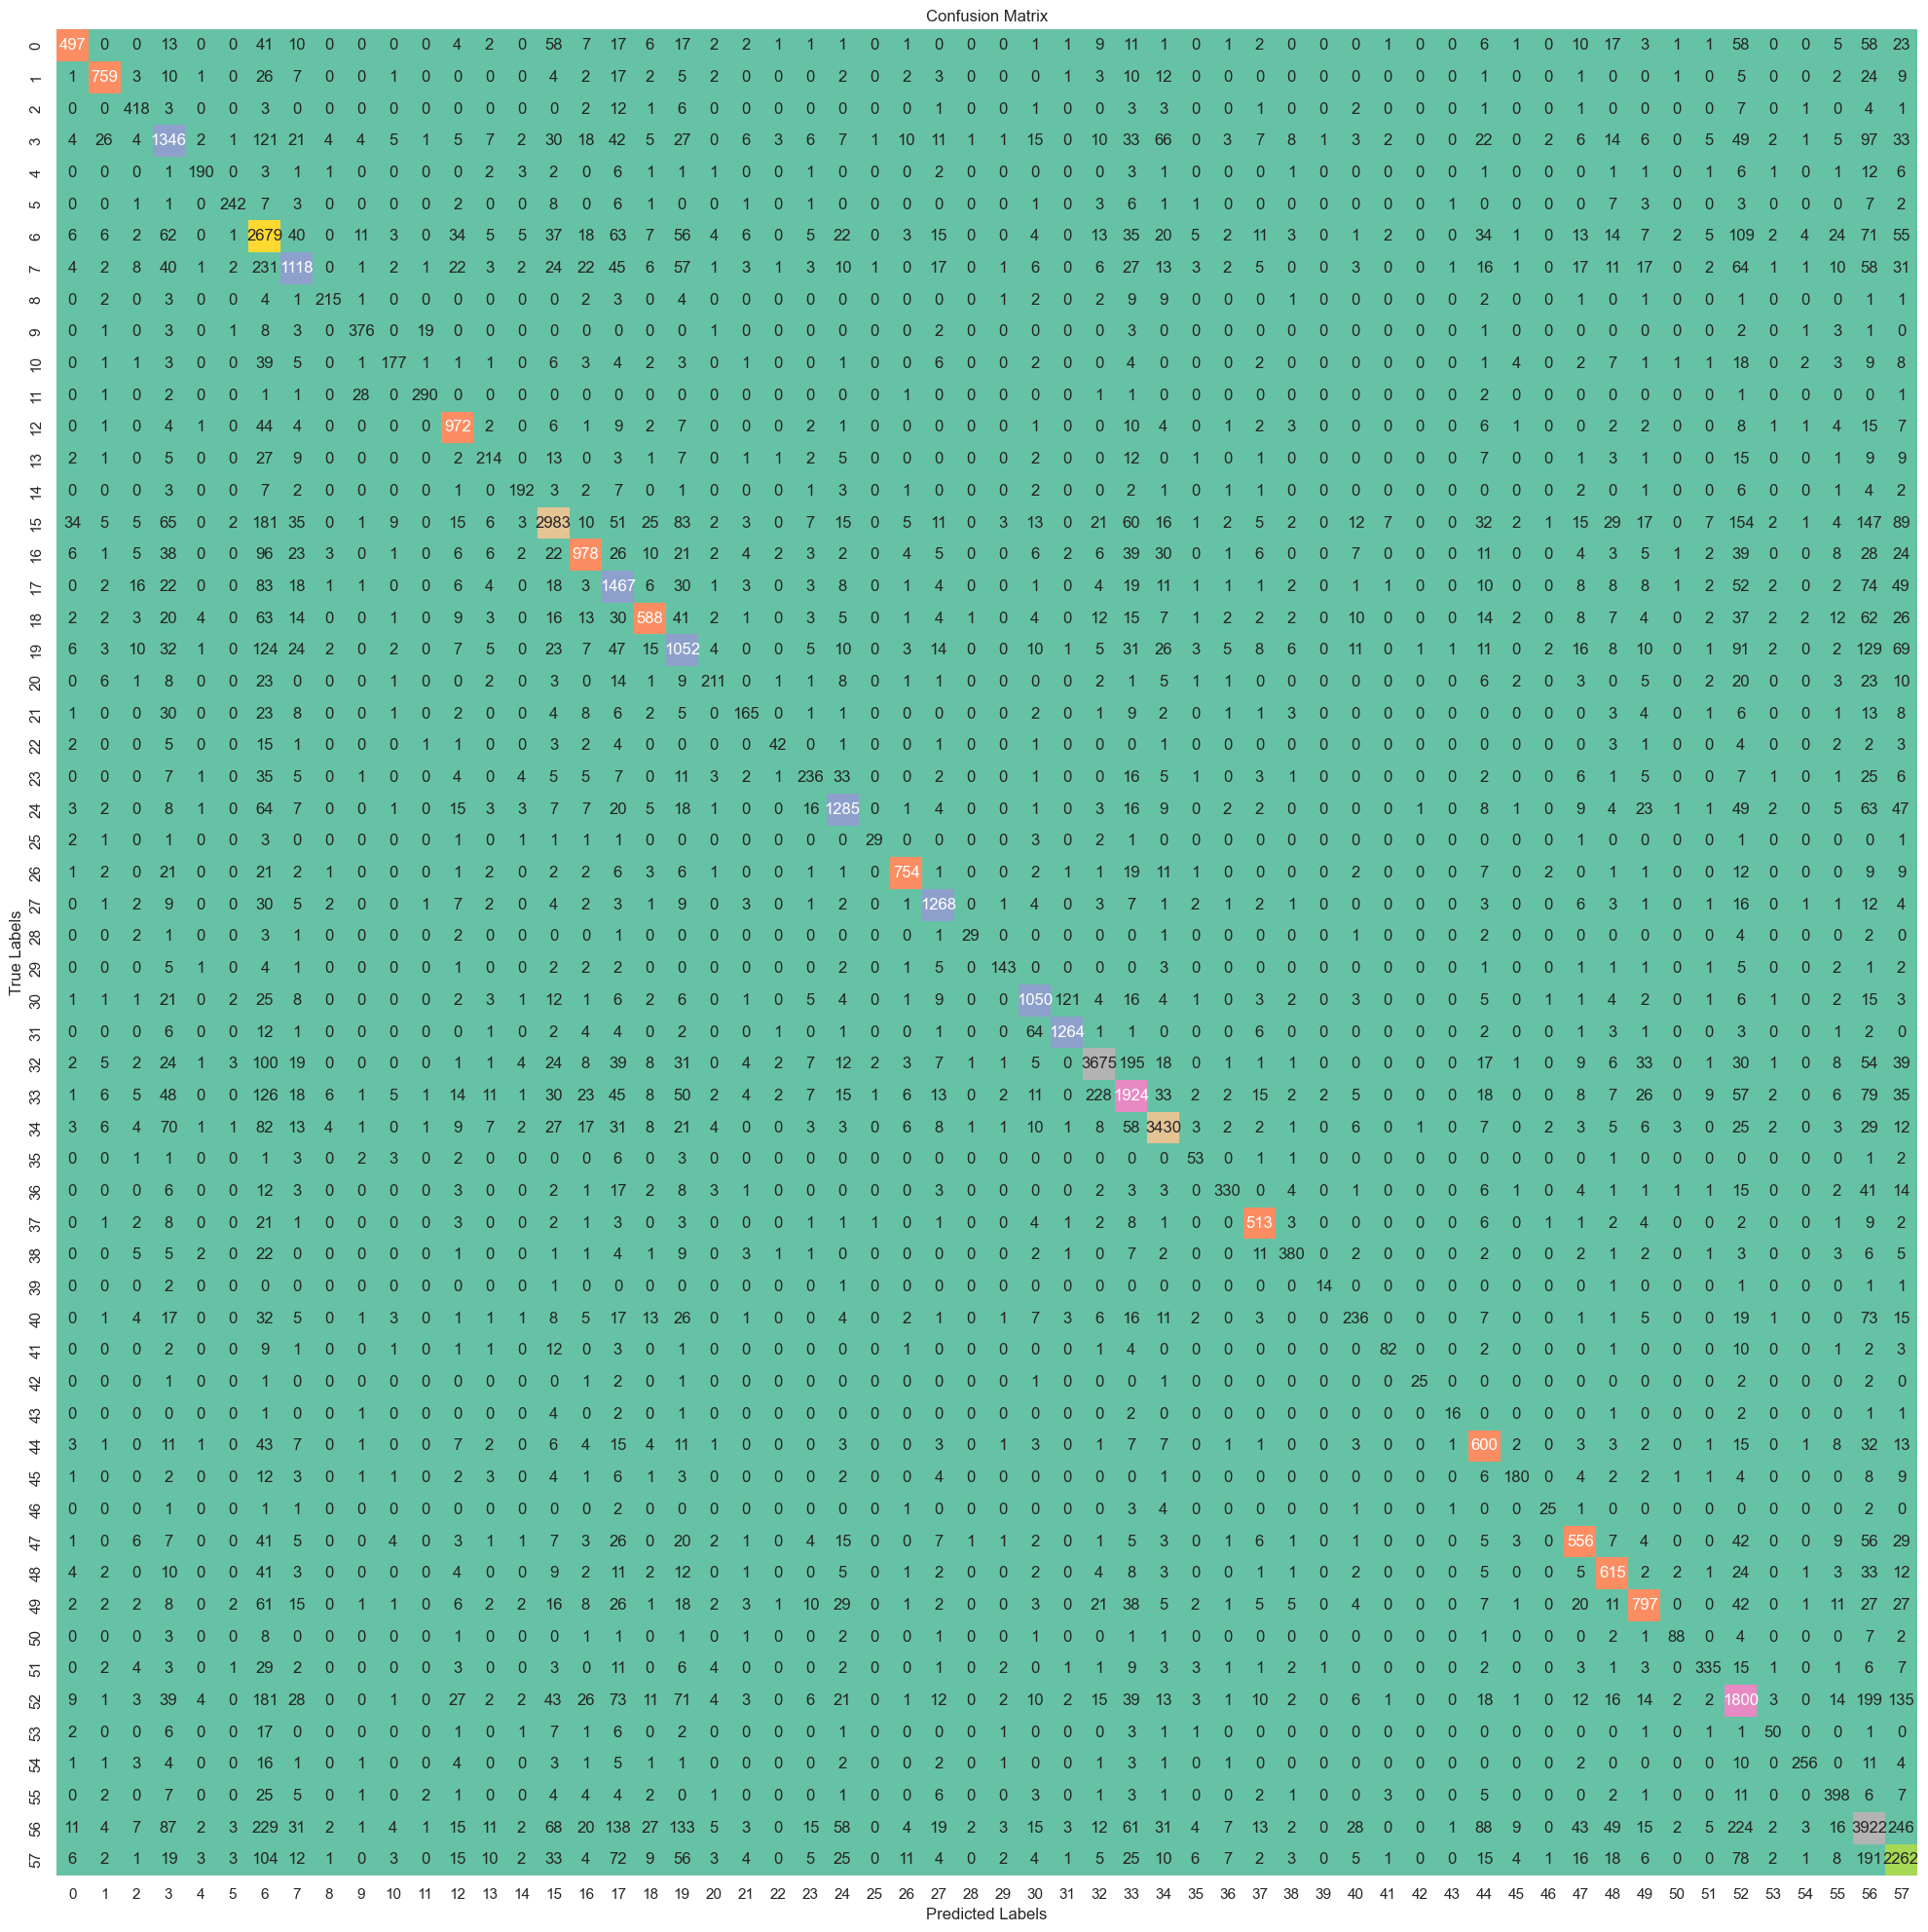

In [28]:
import seaborn as sns

#custom_palette = sns.color_palette("rocket", as_cmap=True)
custom_palette = sns.color_palette("Set2", as_cmap=True)
#custom_palette = sns.color_palette("Blues", as_cmap=True)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_palette, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>VGG</li></ul>
</h4>

* **Fromating method**

In [10]:
def build_protein_histogram_32(dataset, k=50, slide=1, length=32):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'
    
    def calculate_frequencies(sequence, k, length):
        histogram = np.zeros((length, len(amino_acids)))
        for i in range(length):
            #print(i*k, (i*k) + k)
            segment = sequence[i*slide:(i*slide) + k]
            freqs = np.zeros(len(amino_acids))
            for aa in segment:
                if aa in amino_acids:
                    freqs[amino_acids.index(aa)] += 1
                else:
                    freqs[amino_acids.index('X')] += 1
            freqs /= k
            histogram[i, :] = freqs
        return histogram

    def pad_matrix(matrix, dim=(32, 32)):
        matrix1 = np.zeros(dim)
        matrix1[:matrix.shape[0], :matrix.shape[1]] += matrix
        return matrix1
    
    histograms = []
    labels = []
    
    for _, row in dataset.iterrows():
        sequence = row['sequence']
        label = row['class']
        
        if len(sequence) < k + length - 1:
            continue
        
        hist = calculate_frequencies(sequence, k, length)
        pad_hist = pad_matrix(hist)
        histograms.append(pad_hist)
        labels.append(label)
    
    return np.array(histograms), np.array(labels)

In [11]:
X, y = build_protein_histogram_32(dataset, k=50, slide=1, length=32)
print(X.shape)
print(y)

(316790, 32, 32)
[30 30 30 ... 57 57 57]


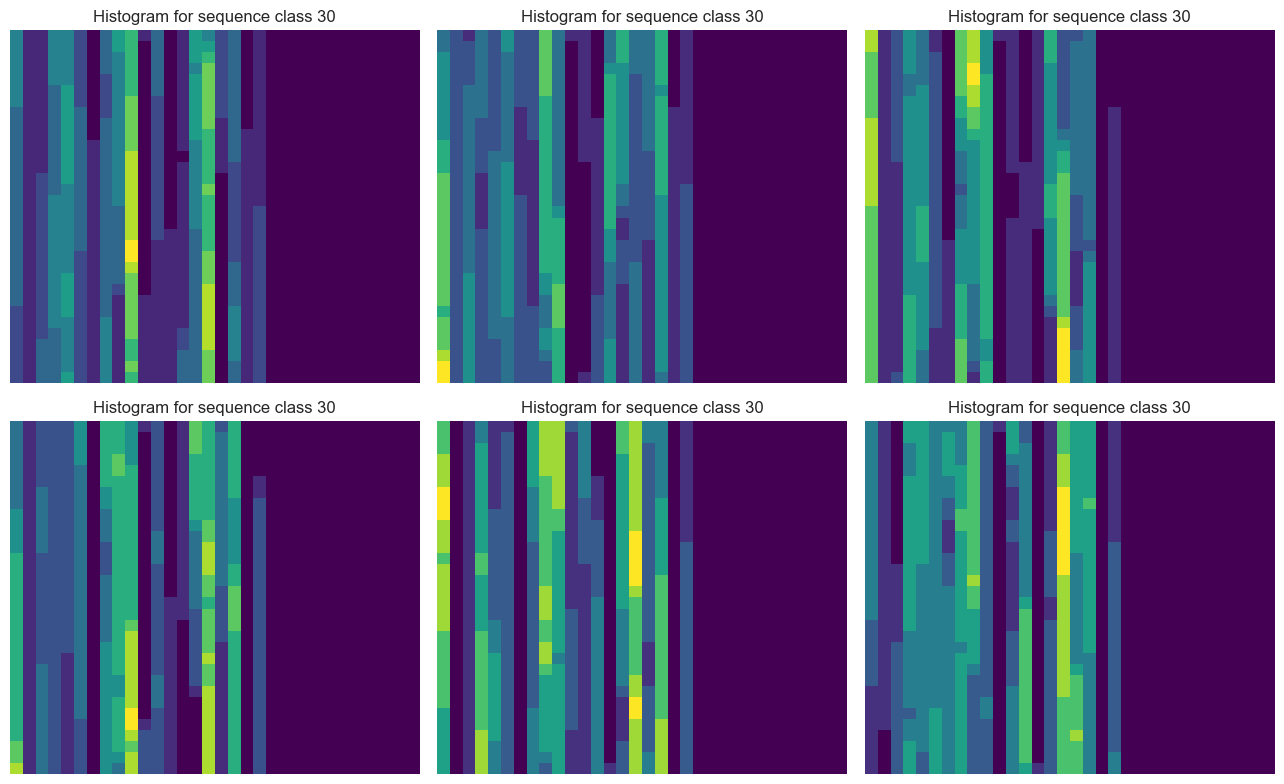

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
for i in range(6):
    row = i // 3
    col = i % 3
    visualize_matrix(X[i], axes[row, col], title=f"Histogram for sequence class {y[i]}")

plt.tight_layout()
plt.show()

In [13]:
X_ = np.array([np.repeat(image[:, :, np.newaxis], 3, axis=-1) for image in X])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify=y) #, random_state=42

In [15]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (253432, 32, 32, 3)
X_test: (63358, 32, 32, 3)
y_train: (253432,)
y_test: (63358,)


* <span style="color: blue; font-weight: bold;">MODEL 2: VGG16 </span>

In [16]:
name="VGG16"
# Configuration de VGG16
def vgg16_model(input_shape=(X.shape[1], X.shape[2], 3), num_classes=NUM_CLASS):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output, name=name)
    
    # Compilation du modèle
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

# Build & train the model
model = vgg16_model()
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=25, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 3535s 1s/step - accuracy: 0.0137 - loss: nan - val_accuracy: 0.0140 - val_loss: nan
Epoch 2/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 1968s 621ms/step - accuracy: 0.0138 - loss: nan - val_accuracy: 0.0140 - val_loss: nan
Epoch 3/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 1944s 614ms/step - accuracy: 0.0139 - loss: nan - val_accuracy: 0.0140 - val_loss: nan
Epoch 4/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 1929s 609ms/step - accuracy: 0.0142 - loss: nan - val_accuracy: 0.0140 - val_loss: nan
Epoch 5/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 1945s 614ms/step - accuracy: 0.0143 - loss: nan - val_accuracy: 0.0140 - val_loss: nan
Epoch 6/25
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 1971s 622ms/step - accuracy: 0.0141 - loss: nan - val_accuracy: 0.0140 - val_loss: nan

[Train Accuracy: 1.40% - Test Accuracy: 1.40%]


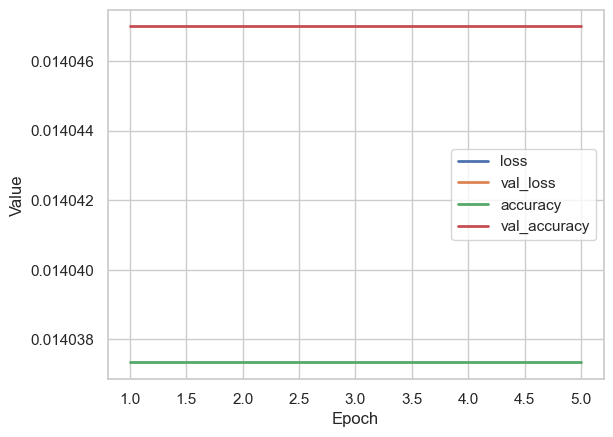

In [17]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, [], len(dataset)]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])